In [1]:
import sys

import torch

sys.path.append("..")


In [2]:
import random
from typing import Any

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import font_manager as fm
from torchvision.utils import make_grid


In [3]:
from data.dataloader import LowLightDataModule
from engine.engine import LightningEngine
from model.model import LowLightEnhancerLightning


/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
font_path = "../times.ttf"
prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.size"] = 48


In [5]:
def get_hparams() -> dict[str, Any]:
    hparams: dict[str, Any] = {
        # Engine
        "seed": 42,
        "max_epochs": 100,
        "accelerator": "gpu",
        "devices": 1,
        "precision": "16-mixed",
        "log_every_n_steps": 5,
        "log_dir": "runs/",
        "experiment_name": "train/",
        "patience": 100,
        # Runner
        "inference": "inference/",
        "train_data_path": "../data/1_train",
        "valid_data_path": "../data/2_valid",
        "bench_data_path": "../data/3_bench",
        "infer_data_path": "../data/4_infer",
        "image_size": 256,
        "batch_size": 4,
        "num_workers": 10,
        # Model
        "embed_dim": 64,
        "num_heads": 4,
        "mlp_ratio": 4,
        "num_resolution": 4,
        "dropout_ratio": 0.2,
        "offset": 0.5,
        "cutoff": 0.1,
    }
    return hparams


In [6]:
hparams: dict[str, Any] = get_hparams()

engine = LightningEngine(
    model_class=LowLightEnhancerLightning,
    hparams=hparams,
    checkpoint_path="../runs/add_vit/version_14/checkpoints/best.ckpt",
)


Seed set to 42


Loading pretrained model LPIPS from /home/user/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=256,
    batch_size=1,
    num_workers=4,
)

data_module.setup()


In [8]:
predict_loaders = data_module.predict_dataloader()

if isinstance(predict_loaders, (list, tuple)):
    loader = predict_loaders[0]
else:
    loader = predict_loaders
loader_iter = iter(loader)


In [9]:
x, _ = next(loader_iter)

x = x.cuda()
model = engine.model.to("cuda")

resutls = model(x)


In [10]:
def topil(x, batch):
    if batch:
        return (
            (x.permute(1, 2, 0).detach().cpu().numpy() * 255)
            .clip(0, 255)
            .astype(np.uint8)
        )
    else:
        return (
            (x.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255)
            .clip(0, 255)
            .astype(np.uint8)
        )


In [11]:
low_rgb = topil(resutls["low"]["rgb"], False)
low_luminance = topil(resutls["low"]["luminance"], False)
low_chroma_red = topil(resutls["low"]["chroma_red"], False)
low_chroma_blue = topil(resutls["low"]["chroma_blue"], False)
low_illuminance = topil(resutls["low"]["illuminance"], False)
low_reflectance = topil(resutls["low"]["reflectance"], False)
enhanced_luminance = topil(resutls["enhanced"]["luminance"], False)
enhanced_chroma_red = topil(resutls["enhanced"]["chroma_red"], False)
enhanced_chroma_blue = topil(resutls["enhanced"]["chroma_blue"], False)
enhanced_rgb = topil(resutls["enhanced"]["rgb"], False)


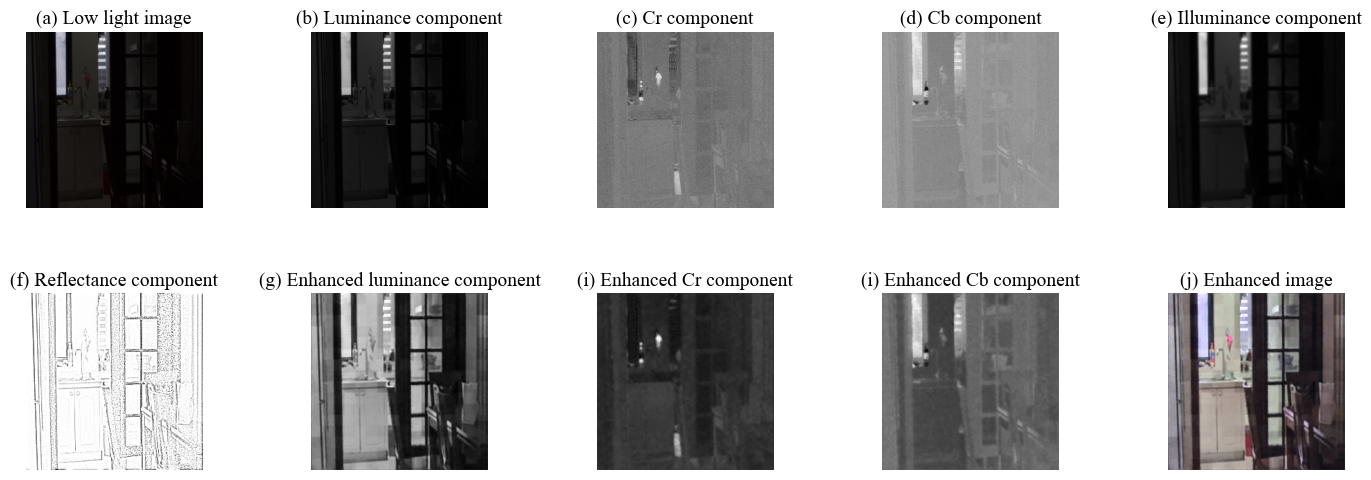

In [12]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 5, 1)
plt.imshow(X=low_rgb)
plt.title(label="(a) Low light image", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 2)
plt.imshow(X=low_luminance, cmap="gray")
plt.title(label="(b) Luminance component", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 3)
plt.imshow(X=low_chroma_red, cmap="gray")
plt.title(label="(c) Cr component", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 4)
plt.imshow(X=low_chroma_blue, cmap="gray")
plt.title(label="(d) Cb component", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 5)
plt.imshow(X=low_illuminance, cmap="gray")
plt.title(label="(e) Illuminance component", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 6)
plt.imshow(X=low_reflectance, cmap="gray")
plt.title(label="(f) Reflectance component", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 7)
plt.imshow(X=enhanced_luminance, cmap="gray")
plt.title(label="(g) Enhanced luminance component", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 8)
plt.imshow(X=enhanced_chroma_red, cmap="gray")
plt.title(label="(i) Enhanced Cr component", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 9)
plt.imshow(X=enhanced_chroma_blue, cmap="gray")
plt.title(label="(i) Enhanced Cb component", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.subplot(2, 5, 10)
plt.imshow(X=enhanced_rgb)
plt.title(label="(j) Enhanced image", fontproperties=prop, fontsize=14)
plt.axis(False)

plt.tight_layout()
plt.show()


In [21]:
cv2.imwrite(
    filename="../runs/image/00_low_x.jpg",
    img=cv2.cvtColor(src=low_rgb, code=cv2.COLOR_RGB2BGR,),
)
cv2.imwrite(
    filename="../runs/image/01_low_y.jpg",
    img=low_luminance,
)
cv2.imwrite(
    filename="../runs/image/02_low_cr.jpg",
    img=low_chroma_red,
)
cv2.imwrite(
    filename="../runs/image/03_low_cb.jpg",
    img=low_chroma_blue,
)
cv2.imwrite(
    filename="../runs/image/04_low_il.jpg",
    img=low_illuminance,
)
cv2.imwrite(
    filename="../runs/image/05_low_re.jpg",
    img=low_reflectance,
)
cv2.imwrite(
    filename="../runs/image/06_enh_y.jpg",
    img=enhanced_luminance,
)
cv2.imwrite(
    filename="../runs/image/07_enh_cr.jpg",
    img=enhanced_chroma_red,
)
cv2.imwrite(
    filename="../runs/image/08_enh_cb.jpg",
    img=enhanced_chroma_blue,
)
cv2.imwrite(
    filename="../runs/image/09_enh_x.jpg",
    img=cv2.cvtColor(src=enhanced_rgb, code=cv2.COLOR_RGB2BGR,),
)


True

In [14]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=256,
    batch_size=4,
    num_workers=4,
)

data_module.setup()


In [15]:
predict_loaders = data_module.predict_dataloader()

if isinstance(predict_loaders, (list, tuple)):
    loader = predict_loaders[0]
else:
    loader = predict_loaders
loader_iter = iter(loader)


In [16]:
all_x = []
all_eh = []

for _ in range(3):
    b_x, _ = next(loader_iter)
    b_x = b_x.cuda()

    model = engine.model.to("cuda")

    resutls = model(b_x)

    all_x.append(b_x.cpu())
    all_eh.append(resutls["enhanced"]["rgb"])


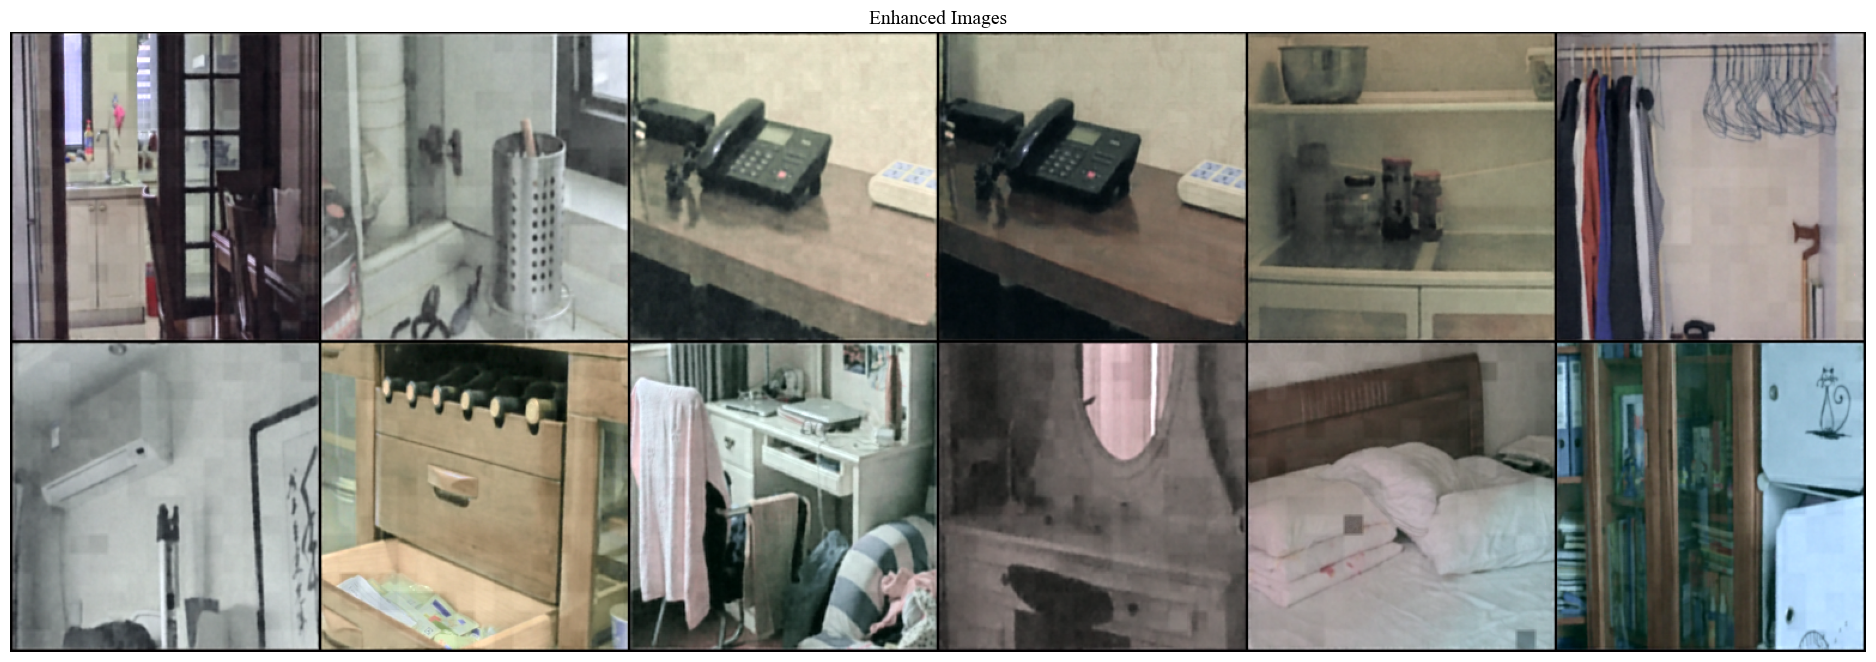

In [17]:
all_x_tensor = torch.cat(tensors=all_x, dim=0)
all_eh_tensor = torch.cat(tensors=all_eh, dim=0)

grid_x = make_grid(tensor=all_x_tensor, nrow=6, padding=2)
grid_eh = make_grid(tensor=all_eh_tensor, nrow=6, padding=2)

np_x = topil(grid_x, True)
np_eh = topil(grid_eh, True)

plt.figure(figsize=(20, 10))
plt.title(label="Enhanced Images", fontproperties=prop, fontsize=14)
plt.imshow(X=np_eh)
plt.axis(False)

plt.tight_layout()
plt.show()


In [22]:
cv2.imwrite(
    filename="../runs/image/10_np_x.jpg",
    img=cv2.cvtColor(src=np_x, code=cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    filename="../runs/image/11_np_eh.jpg",
    img=cv2.cvtColor(src=np_eh, code=cv2.COLOR_RGB2BGR),
)



True